# Test for LW-w LRF 

## Import package

In [14]:
import h5py
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

## Load data

In [ ]:
w_comp = {}

# Load composited W profile
with h5py.File("/work/b11209013/2025_Research/regression/IMERG_ERA5.h5", "r") as ds:
    w_comp_grp = ds["w_composite"]

    for key in w_comp_grp.keys():
        w_comp[key] = np.array(w_comp_grp.get(key))

# Load linear response functions and eofs
with h5py.File("/home/b11209013/2025_Research/Obs/Files/ERA5/LRF_LW_w.h5", "r") as f:
    lrf = np.array(f.get("LRF"))
    eofs = np.array(f.get("EOF"))

## Predict Corresponding Radiative Heating

In [16]:
# decompose vertical motion dataset
w_comp_decomp = {}

for key in w_comp.keys():

    pcs = np.linalg.inv(eofs.T @ eofs) @ eofs.T @ w_comp[key]
    w_comp_decomp[key] = pcs

# predict radiative heating PC
LR_pred = {}
LR_prof_pred = {}

for key in w_comp.keys():
    LR_pred[key] = lrf @ w_comp_decomp[key]

# Reconstruct radiative heating

LR_recon = {}

for key in w_comp.keys():
    LR_recon[key] = eofs @ LR_pred[key]

## Plot corresponding radiative heating profile

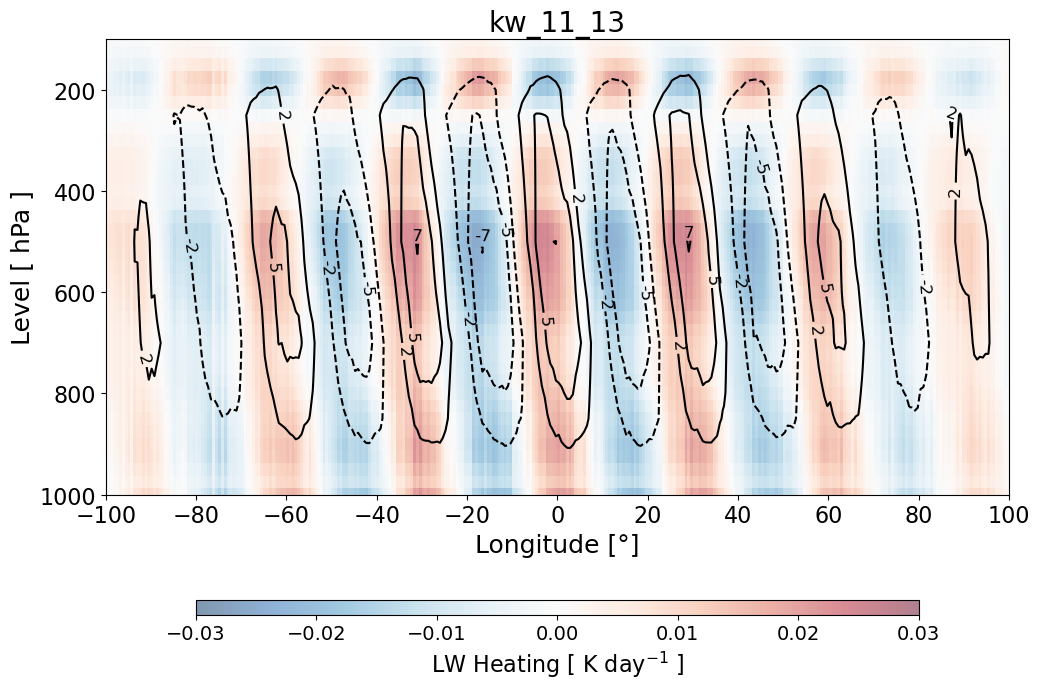

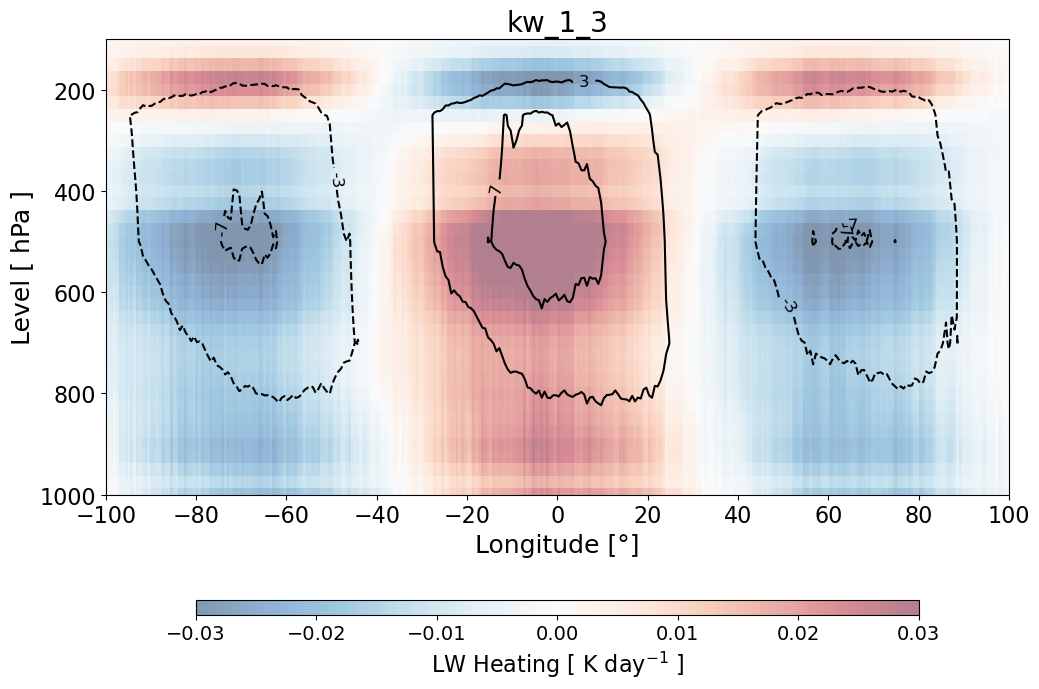

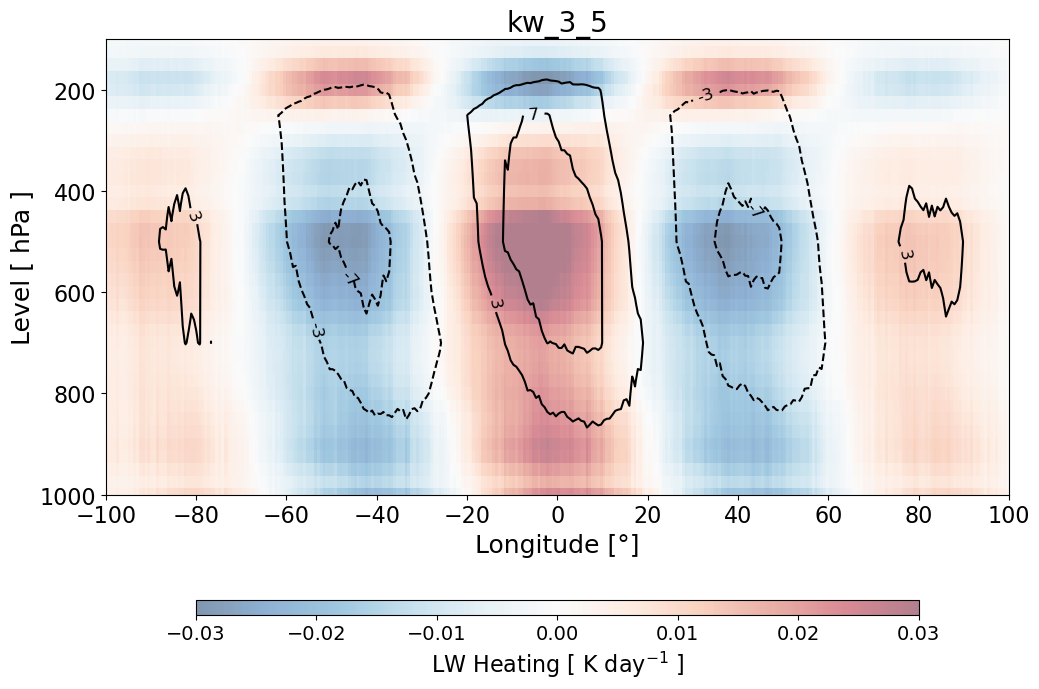

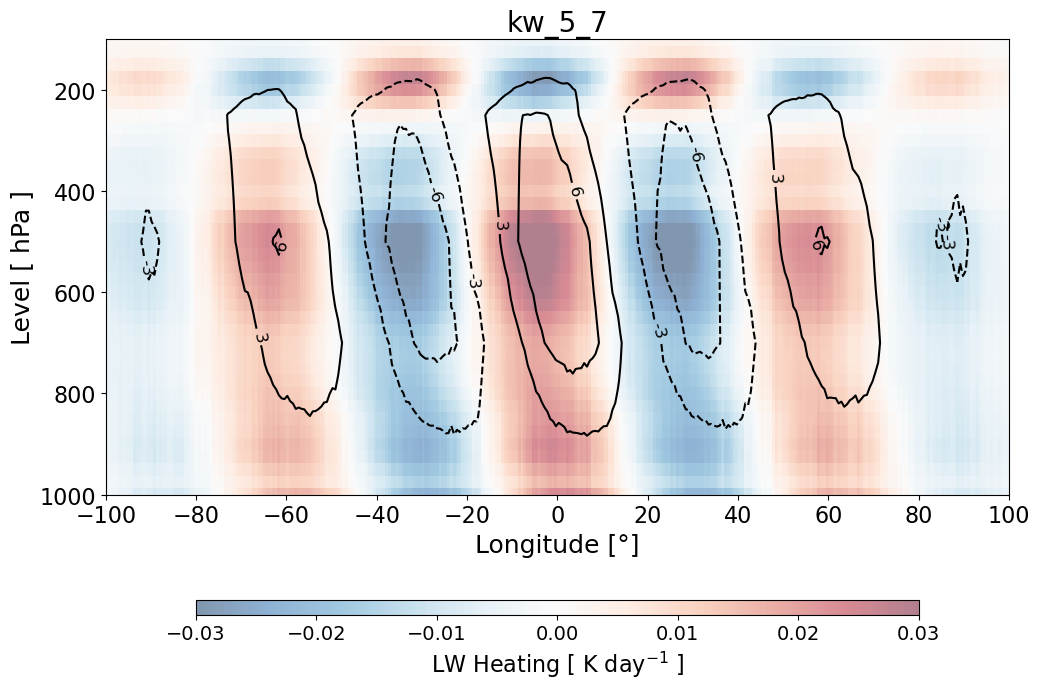

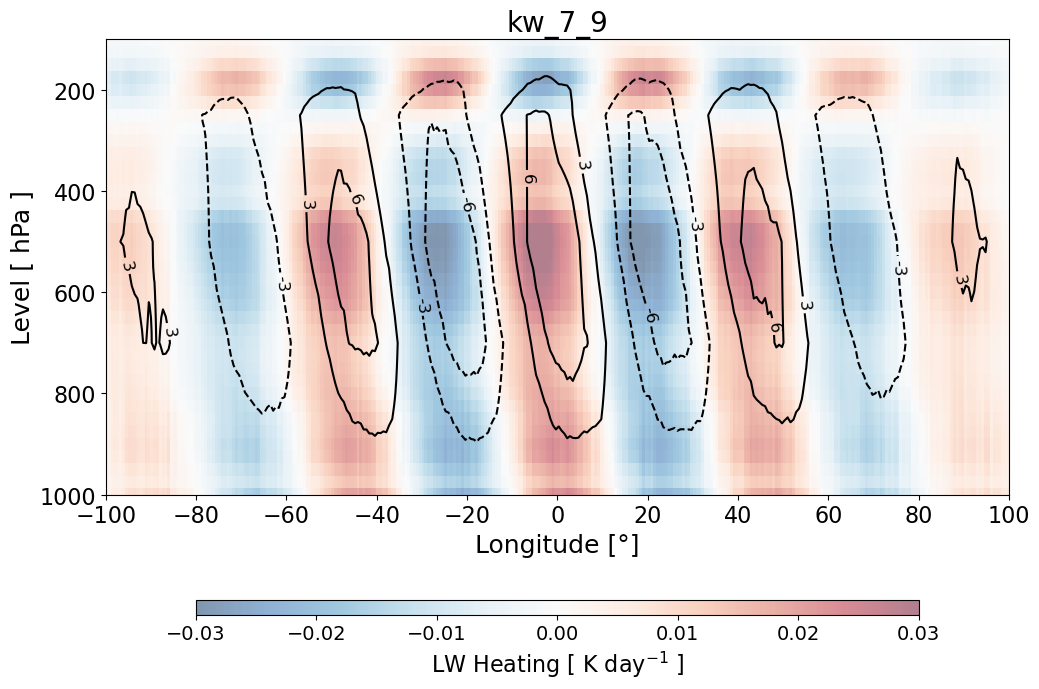

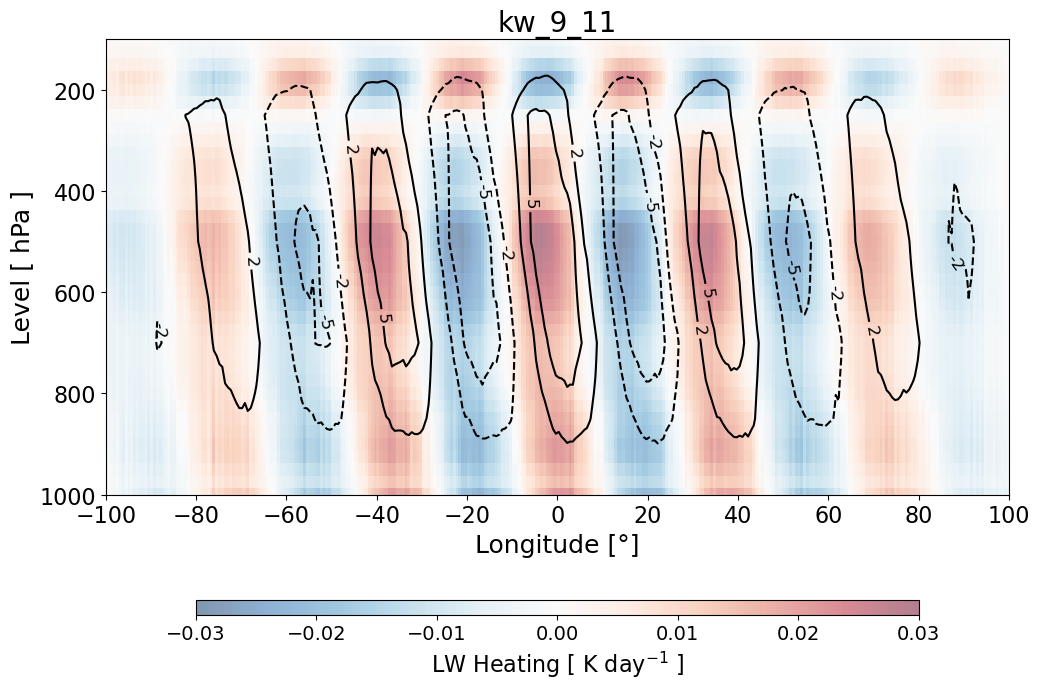

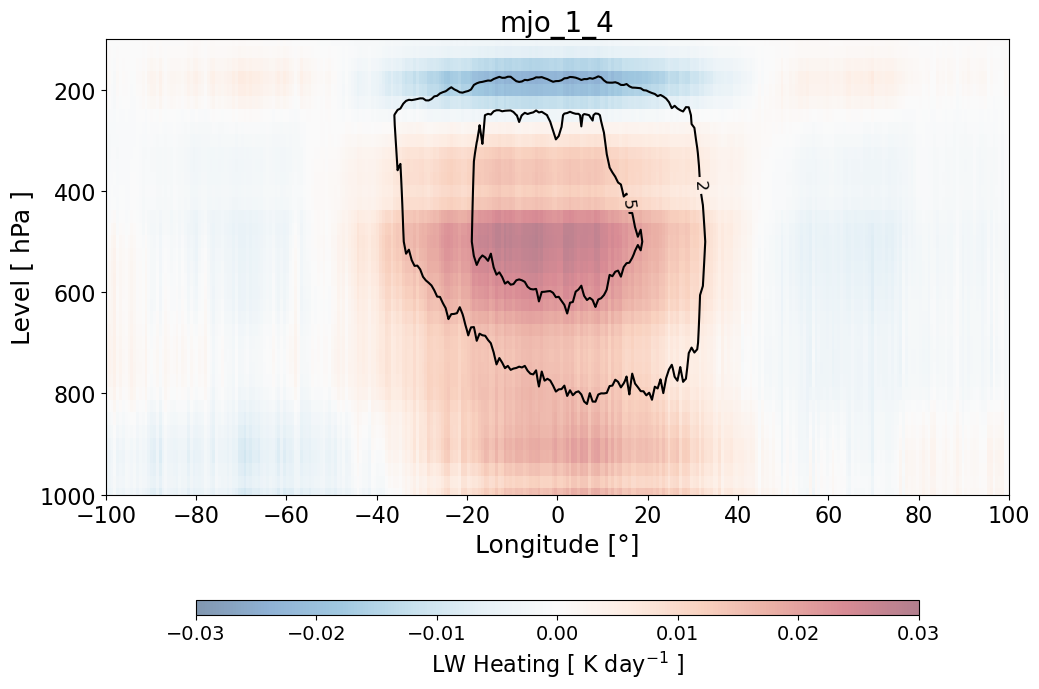

In [17]:
for i in range(len(w_comp.keys())):

    w_max = np.max(np.abs(-LR_recon[list(w_comp.keys())[i]])*1e3)
    w_levels = np.linspace(-w_max, w_max, 21)
    w_levels = [float(i) for i in w_levels if i != 0]


    fig = plt.figure(figsize=(10.5, 7.2))

    pcr = plt.pcolormesh(
        np.linspace(-180, 180, 576),
        np.linspace(1000, 100, 37),
        LR_recon[list(w_comp.keys())[i]],
        norm = TwoSlopeNorm(vmin=-0.03, vcenter=0, vmax=0.03),
        cmap="RdBu_r", alpha=0.5
    )
    ct = plt.contour(
        np.linspace(-180, 180, 576),
        np.linspace(1000, 100, 37),
        -w_comp[list(w_comp.keys())[i]]*1e3,
        levels=w_levels,
        colors="k"
    )
    plt.xticks(np.linspace(-100, 100, 11), fontsize=16)
    plt.yticks(np.linspace(1000, 200, 5), fontsize=16)
    plt.xlim(-100, 100)
    plt.ylim(1000, 100)
    plt.xlabel("Longitude [°]", fontsize=18)
    plt.ylabel("Level [ hPa ]", fontsize=18)
    plt.title(f"{list(w_comp.keys())[i]}", fontsize=20)
    plt.clabel(ct, fmt="%d", colors="k", fontsize=12)
    cbar = plt.colorbar(pcr, orientation="horizontal", pad=0.16, shrink=0.8, aspect=50)
    cbar.set_label("LW Heating [ K day$^{-1}$ ]", fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    plt.tight_layout()
    plt.savefig(f"/home/b11209013/2025_Research/Obs/Figure/CloudRad_w/LW/{list(w_comp.keys())[i]}.png", dpi=500)
    plt.show()